In [1]:
# Install necessary libraries (though most are pre-installed in Colab)
!pip install pandas numpy scikit-learn matplotlib seaborn

# Import all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Metrics for evaluation
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
from google.colab import files

print("Please upload the 'Agriculture_Crop_Yield.csv' dataset...")
# uploaded = files.upload()

# --- IMPORTANT ---
# Make sure the file name matches what you uploaded.
file_name = "crop_yield.csv"
# -----------------

# Read the dataset into a pandas DataFrame
try:
    if file_name.endswith('.csv'):
        df = pd.read_csv(file_name)
    elif file_name.endswith('.xlsx'):
        df = pd.read_excel(file_name)
    else:
        print(f"Error: Unknown file type for {file_name}")

    print("Dataset loaded successfully!")
    df.head()

except KeyError:
    print("\n--- ERROR ---")
    print(f"File '{file_name}' not found. Did you upload it and spell the name correctly?")
except Exception as e:
    print(f"An error occurred: {e}")

Please upload the 'Agriculture_Crop_Yield.csv' dataset...
Dataset loaded successfully!


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB

--- Descriptive Statistics ---
          Rainfall_mm  Temperature_Celsius  Days_to_Harvest  \
count  1000000.000000       1000000.0000

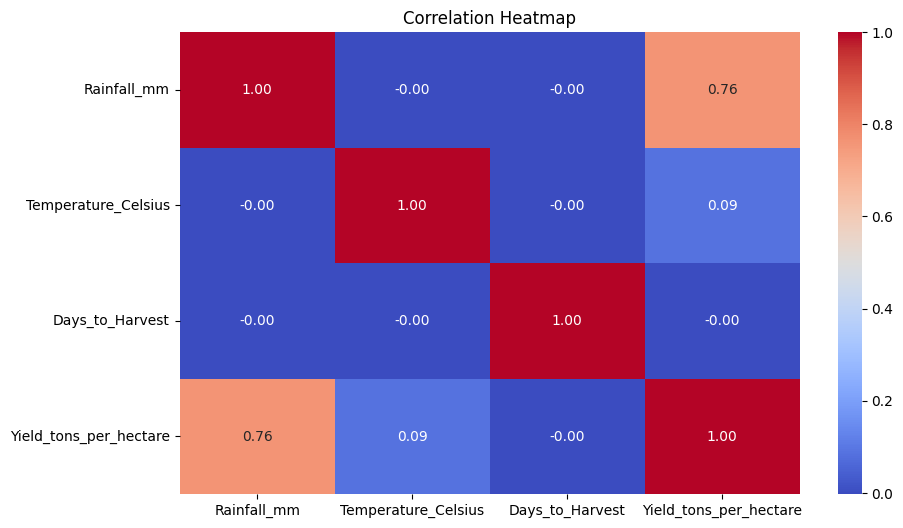

/tmp/ipython-input-1064821022.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


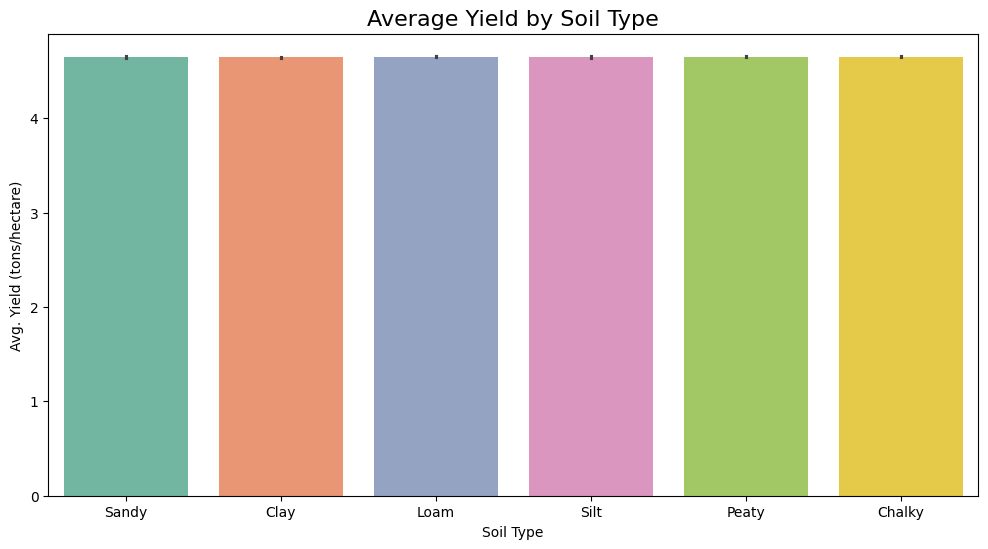

In [3]:
# 1. Basic Information
print("--- Dataset Info ---")
df.info()

# 2. Descriptive Statistics for numerical columns
print("\n--- Descriptive Statistics ---")
print(df.describe())

# 3. Value Counts for key categorical columns
print("\n--- Soil Type Distribution ---")
print(df['Soil_Type'].value_counts())

print("\n--- Crop Distribution ---")
print(df['Crop'].value_counts().head(5)) # Show top 5 crops

# 4. Correlation Heatmap for numerical features
plt.figure(figsize=(10, 6))
# Select only columns that are numeric for the correlation matrix
numeric_cols = df.select_dtypes(include=np.number).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# 5. Relationship between Soil Type and Yield
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x='Soil_Type',
    y='Yield_tons_per_hectare',
    palette='Set2'
)
plt.title('Average Yield by Soil Type', fontsize=16)
plt.ylabel('Avg. Yield (tons/hectare)')
plt.xlabel('Soil Type')
plt.show()

In [4]:
# --- Cell 4 (Corrected) ---

print("--- Starting Simplified Feature Prep ---")

# Make a copy to avoid changing the original dataframe
df_processed = df.copy()

# 1. Drop rows with any missing values FIRST
# This is what's causing the error. We must drop NaNs before converting types.
original_rows = len(df_processed)
df_processed = df_processed.dropna()
print(f"Dropped {original_rows - len(df_processed)} rows with missing data.")

# 2. NOW it is safe to convert boolean (True/False) columns to integers (1/0)
# The columns no longer contain NaN, so .astype(int) will work.
try:
    df_processed['Fertilizer_Used'] = df_processed['Fertilizer_Used'].astype(int)
    df_processed['Irrigation_Used'] = df_processed['Irrigation_Used'].astype(int)
    print("Successfully converted boolean columns to integers.")
except ValueError as e:
    print(f"Error during type conversion: {e}")
    print("There might be non-boolean/non-numeric values in these columns.")

print("--- DataFrame with simple prep ---")
df_processed.head()

--- Starting Simplified Feature Prep ---
Dropped 0 rows with missing data.
Successfully converted boolean columns to integers.
--- DataFrame with simple prep ---


,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,0,1,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,1,1,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,0,0,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,0,1,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,1,1,Cloudy,110,7.248251


In [5]:
# --- Cell 5 (New, Corrected, & Combined) ---

# 1. Define Features (X) and Target (y)
y = df_processed['Yield_tons_per_hectare']
X = df_processed.drop('Yield_tons_per_hectare', axis=1)

# 2. Identify categorical and numerical features
# These are the simplified lists we decided on
categorical_features = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']
numerical_features = [
    'Rainfall_mm',
    'Temperature_Celsius',
    'Days_to_Harvest',
    'Fertilizer_Used',
    'Irrigation_Used'
]

# 3. Define the transformers
# (This is the part that was missing or out of order)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. Create the final preprocessor
# Now, 'numeric_transformer' is defined and this will work
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocessor created successfully!")
print("\n--- Final Simplified Features (X) ---")
print(X.head())

Preprocessor created successfully!

--- Final Simplified Features (X) ---
  Region Soil_Type     Crop  Rainfall_mm  Temperature_Celsius  \
0   West     Sandy   Cotton   897.077239            27.676966   
1  South      Clay     Rice   992.673282            18.026142   
2  North      Loam   Barley   147.998025            29.794042   
3  North     Sandy  Soybean   986.866331            16.644190   
4  South      Silt    Wheat   730.379174            31.620687   

   Fertilizer_Used  Irrigation_Used Weather_Condition  Days_to_Harvest  
0                0                1            Cloudy              122  
1                1                1             Rainy              140  
2                0                0             Sunny              106  
3                0                1             Rainy              146  
4                1                1            Cloudy              110  


In [6]:
# # Create a transformer for numerical features
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# # Create a transformer for categorical features
# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Combine these transformers into a single "preprocessor"
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

In [7]:
# 1. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set has {len(X_train)} samples.")
print(f"Testing set has {len(X_test)} samples.\n")

# --- Import metrics ---
import joblib
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 2. Define the models we want to train
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# 3. Create a dictionary to store our results
model_results = {}

# 4. Loop through each model, train it, and store the results
for name, model in models.items():

    # Create the full pipeline: Preprocess data THEN run the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # --- Save the trained pipeline ---
    file_name = f"crop_yield_{name.lower().replace(' ', '_')}_pipeline.joblib"
    joblib.dump(pipeline, file_name)
    print(f"--- Model Saved: {file_name} ---")

    # --- Make predictions on the TEST set ---
    y_test_pred = pipeline.predict(X_test)

    # === Calculate "Prediction Rate" (Accuracy) ===
    # R² Score: How well the model explains the variance. Higher is better (1.0 = 100%)
    test_r2 = r2_score(y_test, y_test_pred)

    # === Calculate "Inaccuracy Results" (Errors) ===
    # MAE: Mean Absolute Error. The average error in your prediction (in tons/hectare). Lower is better.
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # MSE: Mean Squared Error. Penalizes large errors more. Lower is better.
    test_mse = mean_squared_error(y_test, y_test_pred)

    # RMSE: Root Mean Squared Error. The square root of MSE, putting it in the same unit as your target (tons/hectare). Lower is better.
    test_rmse = np.sqrt(test_mse)

    # Print the results
    print(f"--- {name} Results (on Test Set) ---")
    print(f"Prediction Rate (R² Score): {test_r2 * 100:.2f}%")
    print(f"Inaccuracy (MAE): {test_mae:.4f} tons/hectare")
    print(f"Inaccuracy (RMSE): {test_rmse:.4f} tons/hectare")
    print("-" * (len(name) + 26) + "\n")

    # Store R² results for the graph
    # We also get the training R² to check for overfitting
    y_train_pred = pipeline.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)

    model_results[name] = {
        'Train R² (%)': train_r2 * 100,
        'Test R² (%)': test_r2 * 100
    }

Training set has 800000 samples.
Testing set has 200000 samples.

--- Model Saved: crop_yield_random_forest_pipeline.joblib ---
--- Random Forest Results (on Test Set) ---
Prediction Rate (R² Score): 90.77%
Inaccuracy (MAE): 0.4116 tons/hectare
Inaccuracy (RMSE): 0.5158 tons/hectare
---------------------------------------



In [8]:
import joblib
import os

# Create a directory to save the models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save each trained model
for name, model in models.items():
    # Sanitize the model name for use in a filename
    filename = f'models/{name.replace(" ", "_").lower()}.pkl'
    joblib.dump(model, filename)
    print(f"Model '{name}' saved to {filename}")

Model 'Random Forest' saved to models/random_forest.pkl


In [9]:
# --- This cell assumes your LAST trained model was 'Gradient Boosting' ---
# The 'pipeline' variable should still be in memory from Cell 7

print("--- Feature Importances for Gradient Boosting Model ---")

# 1. Get the trained preprocessor and model from the final pipeline
try:
    preprocessor = pipeline.named_steps['preprocessor']
    model = pipeline.named_steps['regressor']
except NameError:
    print("Error: 'pipeline' variable not found.")
    print("Please re-run Cell 7 (model training) and then run this cell again.")
except KeyError:
    print("Error: Pipeline steps 'preprocessor' or 'regressor' not found.")
else:
    # 2. Get all the final feature names from the preprocessor

    # Get the one-hot-encoded categorical feature names
    cat_feature_names = list(preprocessor.named_transformers_['cat']
                             .get_feature_names_out(categorical_features))

    # The numerical feature names are just the list we already have
    all_feature_names = numerical_features + cat_feature_names

    # 3. Get the feature importances from the trained model
    importances = model.feature_importances_

    # 4. Create and display a DataFrame
    importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(importance_df)

--- Feature Importances for Gradient Boosting Model ---
                     Feature  Importance
0                Rainfall_mm    0.605976
3            Fertilizer_Used    0.195797
4            Irrigation_Used    0.124829
1        Temperature_Celsius    0.027974
2            Days_to_Harvest    0.016077
8                Region_West    0.001601
6               Region_North    0.001600
7               Region_South    0.001599
5                Region_East    0.001595
23   Weather_Condition_Sunny    0.001567
22   Weather_Condition_Rainy    0.001563
21  Weather_Condition_Cloudy    0.001562
18                 Crop_Rice    0.001534
14            Soil_Type_Silt    0.001528
9           Soil_Type_Chalky    0.001526
16               Crop_Cotton    0.001524
11            Soil_Type_Loam    0.001523
12           Soil_Type_Peaty    0.001523
13           Soil_Type_Sandy    0.001523
10            Soil_Type_Clay    0.001519
15               Crop_Barley    0.001518
17                Crop_Maize    0.001515
2

In [10]:
import os

# Get the file size of the saved Random Forest pipeline
file_name = "crop_yield_random_forest_pipeline.joblib"
file_size_bytes = os.path.getsize(file_name)

# Convert bytes to megabytes
file_size_mb = file_size_bytes / (1024 * 1024)

print(f"Size of the Random Forest model file ('{file_name}'): {file_size_mb:.2f} MB")

Size of the Random Forest model file ('crop_yield_random_forest_pipeline.joblib'): 6943.19 MB


In [11]:
# from google.colab import drive
# import os

# # Mount Google Drive
# drive.mount('/content/drive')

# # Define the source and destination paths
# source_path = "crop_yield_random_forest_pipeline.joblib"
# destination_path = "/content/drive/MyDrive/crop_yield_random_forest_pipeline.joblib" # You can change the destination path

# # Copy the file
# # Using Python's shutil module or a shell command are both options.
# # Let's use a shell command for simplicity here.
# !cp "{source_path}" "{destination_path}"

# print(f"Model file copied to: {destination_path}")

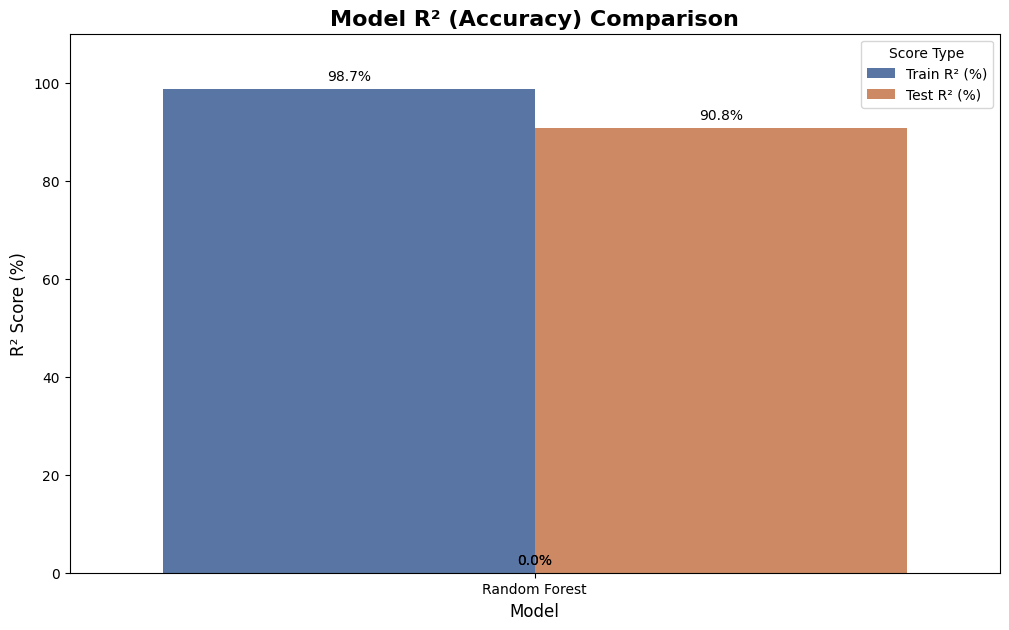

In [12]:
# Convert the results dictionary into a pandas DataFrame for easy plotting
results_df = pd.DataFrame(model_results).T.reset_index()
results_df = results_df.rename(columns={'index': 'Model'})

# "Melt" the DataFrame to a "long" format, which is what seaborn likes
plot_df = results_df.melt(id_vars='Model', var_name='Metric', value_name='R² Score (%)')

# Create the bar plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=plot_df,
    x='Model',
    y='R² Score (%)',
    hue='Metric',
    palette=['#4C72B0', '#DD8452'] # Blue for Train, Orange for Test
)

# Add titles and labels
plt.title('Model R² (Accuracy) Comparison', fontsize=16, fontweight='bold')
plt.ylabel('R² Score (%)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 110) # Set Y-axis from 0% to 110%
plt.legend(title='Score Type')

# Add the percentage labels on top of each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontweight='medium'
    )

plt.show()

In [13]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYR